In [41]:
%pylab inline
import os
from acoustics.generator import Generator
from acoustics.signal import Spectrum
from acoustics.building_acoustics_measurement import BuildingAcousticsMeasurement

Populating the interactive namespace from numpy and matplotlib


In [46]:
sampling_freq = 11025.
d = 10.
f_start = 100.
f_stop = 5000.
fraction = 3
result_dir = '../../data/results/SPL/'

building_acoustics_measurement = BuildingAcousticsMeasurement(fs=sampling_freq, f_start=100., f_stop=3150.,
                                                              fraction=fraction)
spectrum = Spectrum()
gen =  Generator(fs=sampling_freq, duration=d)

_, inverse_signal = gen.sine_sweep([f_start, f_stop])

def get_immediate_subdirectories(root_directory):
    return [name for name in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, name))]

def load_data(file_path, normalize=False):
    data =  np.load(file_path)
    if normalize:
        data = data / data.max()
    return data

def compute_ir(room_response):
    ir = gen.estimate_impulse_response(room_response, inverse_signal)
    ir = ir[:int(sampling_freq*1.5)]
    return ir
    

def compute_reverberation(impulse_response):
    return building_acoustics_measurement.t60_impulse(measured_impulse_response=impulse_response, rt='t10')

def compute_spl(signal):
    octave_bands, power, power_dB = spectrum.fractional_octaves(
            signal, sampling_freq, frequencies=building_acoustics_measurement.octave_bands, fraction=fraction)
    return power_dB


def get_mean(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    l_bound = mean - std
    u_bound = mean + std
    return mean, l_bound, u_bound

def plot_data(y_data, x_data=None, title=None, y_label=None, x_label=None, legend=None, scale='linear',
              multi_plot=False, fill_plot=False, fills=None, file_name=None, args=None):
    colors = ['b', 'g']
    fig, ax = plt.subplots()
    if x_data is None:
        if multi_plot:
            for yy in y_data:
                ax.plot(yy)
        else:
            ax.plot(y_data)
            
    else:
        if multi_plot:
            for ii in xrange(len(y_data)):
                # ax.plot(x_data, y_data[ii], color=colors[ii], label=legend[ii])
                ax.plot(x_data, y_data[ii])
        else:
            ax.plot(x_data, y_data, label='mean')
            
    if fill_plot:
        ax.fill_between(x_data, fills[0], fills[1], alpha=0.4, label='std')
        
    ax.set_xscale(scale)
    if args is not None:
        ax.set_xticks(args)
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid()
    if file_name is not None:
        file_path = result_dir + file_name
        fig.savefig(file_path)

def plot_spectrogram(root_dir, NFFT=4096, args='background'):
    def visualize_spectrogram(data, i):
        ax = plt.subplot(num_rows, num_cols, (i))
        ax.axis()
        spectrum = np.abs(np.fft.rfft(data))
        vmin = 20 * np.log10(np.max(spectrum)) - 60
        
        Pxx, freqs, bins, im = ax.specgram(data, NFFT=NFFT, Fs=sampling_freq, noverlap=NFFT/2, mode='magnitude',
                                           vmin=vmin)
        
        if ((i-1)%3) == 0:
            ax.set_ylabel('Frequency [Hz]')
        if (i > (num_rows * num_cols - num_cols)):
            ax.set_xlabel('Time [sec]')
        if (i%3) == 0:
            CB = plt.colorbar(im, shrink=0.8, extend='both')
            CB.ax.set_ylabel('Power [dB]')
            
        return

    data_folders = get_immediate_subdirectories(root_dir)
    num_cols = 3
    num_rows = 5
    fig, axes = plt.subplots(num_rows, num_cols)
    
    count = 1
    
    for data_foo in data_folders:
        sub_foos = get_immediate_subdirectories(root_dir + data_foo)
        
        for foo in sub_foos:
            if foo == args:
                files = os.listdir(root_dir + data_foo + '/' + foo)
                
                for f in files:
                    file_path = root_dir + data_foo + '/' + foo + '/' + f
                    data = np.load(file_path)
                    visualize_spectrogram(data, count)
                    count += 1                    
    plt.show()
        

def rt60_test(root_dir, args='source'):
    data_folders = get_immediate_subdirectories(root_dir)
    
    count = 0
    for data_foo in data_folders:
        sub_foos = get_immediate_subdirectories(root_dir + data_foo)
        
        for foo in sub_foos:
            if foo == args:
                files = os.listdir(root_dir + data_foo + '/' + foo)
                rt60_list = list()
                
                for f in files:
                    file_path = root_dir + data_foo + '/' + foo + '/' + f
                    
                    room_response = load_data(file_path)
                    impulse_response = compute_ir(room_response)
                    rt60 = compute_reverberation(impulse_response)
                    rt60_list.append(rt60)
                    
                octave_bands = building_acoustics_measurement.octave_bands
                ticks = np.asarray(octave_bands, dtype=np.int)[::2]
                rt60_array = np.asarray(rt60_list)
                
                rt60_mean, l_bound, u_bound = get_mean(rt60_array)
                
                plot_data(rt60_mean, x_data=octave_bands, y_label='Reverberation time [sec]',
                          x_label='Frequency [Hz]', scale='log', fill_plot=True, fills=[l_bound, u_bound],
                          file_name=data_foo+'_'+str(count), args=ticks)
        count +=1

def spl_test(root_dir, args='source'):
    data_folders = get_immediate_subdirectories(root_dir)
    
    count = 0
    for data_foo in data_folders:
        sub_foos = get_immediate_subdirectories(root_dir + data_foo)
        
        for foo in sub_foos:
            if foo == args:
                files = os.listdir(root_dir + data_foo + '/' + foo)
                spl_list = list()
                
                for f in files:
                    file_path = root_dir + data_foo + '/' + foo + '/' + f
                    
                    signal = load_data(file_path)
                    spl = compute_spl(signal)
                    spl_list.append(spl)
                    
                octave_bands = building_acoustics_measurement.octave_bands
                ticks = np.asarray(octave_bands, dtype=np.int)[::2]
                spl_array = np.asarray(spl_list)
                
                spl_mean, l_bound, u_bound = get_mean(spl_array)
                
                plot_data(spl_mean, x_data=octave_bands, y_label='Sound Pressure Level [dB]',
                          x_label='Frequency [Hz]', scale='log', fill_plot=True, fills=[l_bound, u_bound],
                          file_name=data_foo+'_'+str(count), args=ticks)
        count += 1

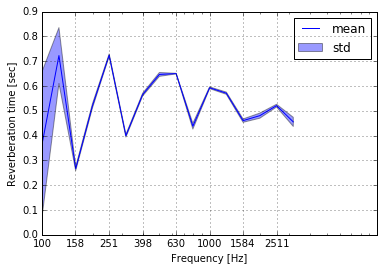

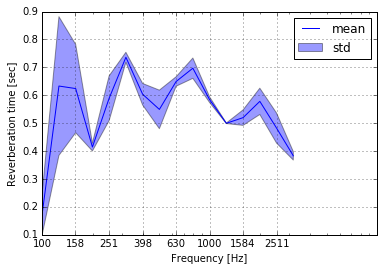

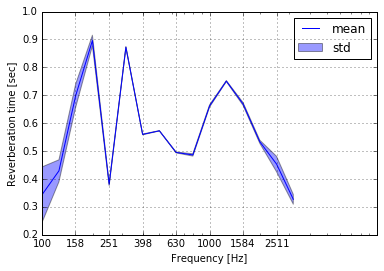

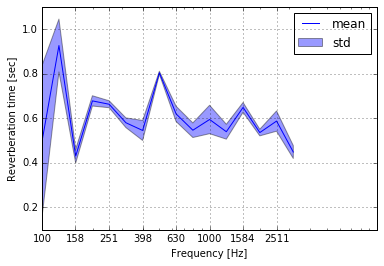

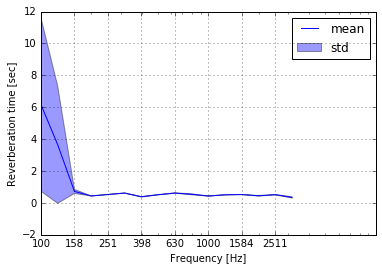

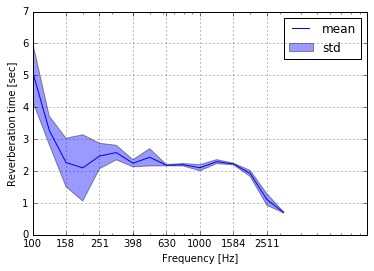

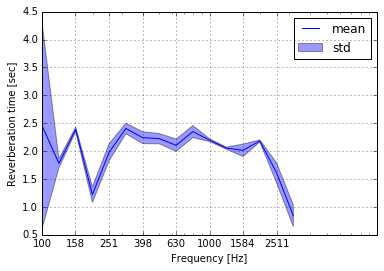

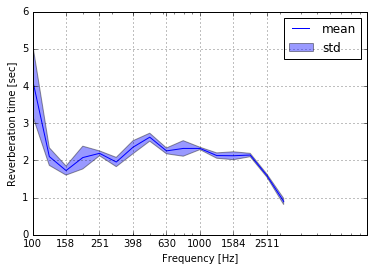

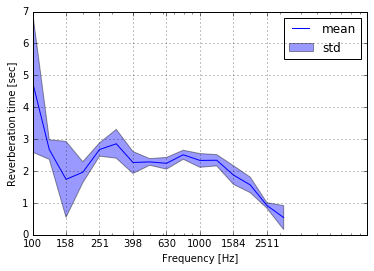

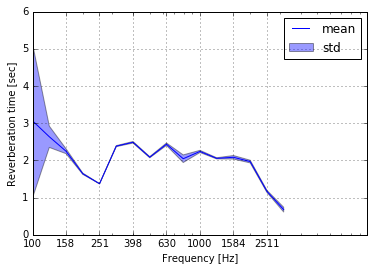

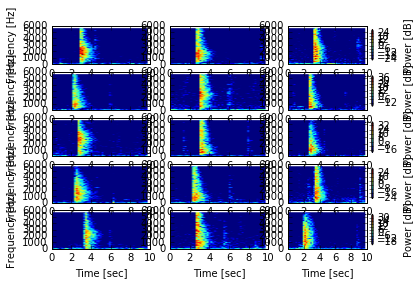

In [31]:
rt60_test('../../data/RT-Test/training-room/')
rt60_test('../../data/RT-Test/stair-case/')
plot_spectrogram('../../data/RT-Test/stair-case/')

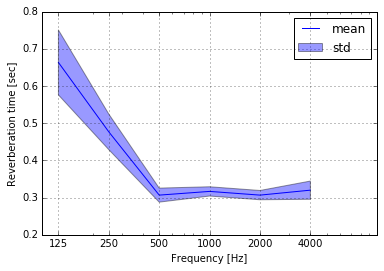

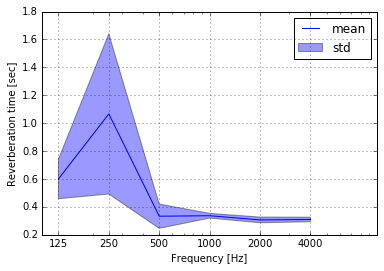

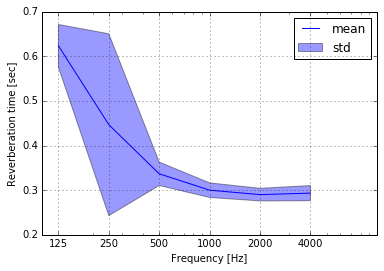

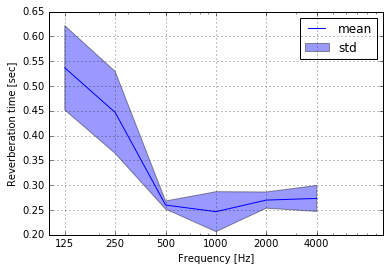

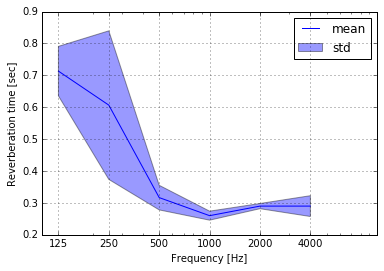

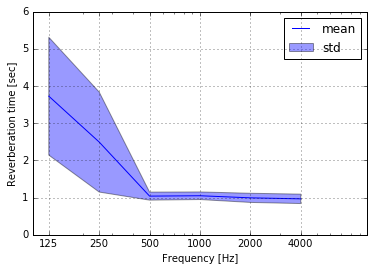

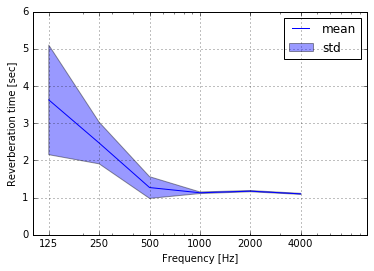

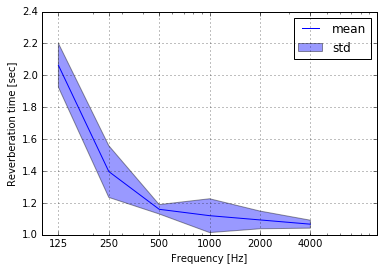

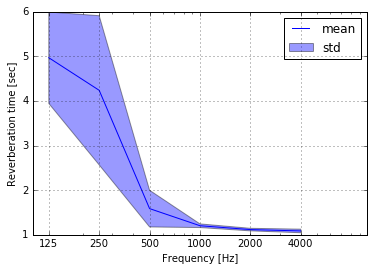

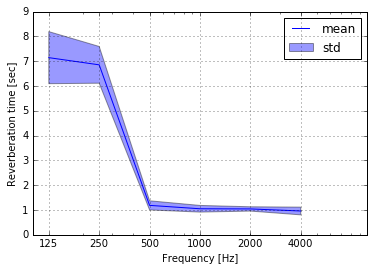

In [55]:
def plot_app_data(measured_pos, freq, y_label, file_names=None):
    i = 0
    for pos in measured_pos:
        pos_mean, pos_l_bound, pos_u_bound = get_mean(pos)
        ticks = np.asarray(freq, dtype=np.int)[::1]
        
        if file_names is not None:
            plot_data(pos_mean, x_data=octave_bands, y_label=y_label,
                  x_label='Frequency [Hz]', scale='log', fill_plot=True, fills=[pos_l_bound, pos_u_bound],
                  file_name=file_names[i], args=ticks)
        else:
            plot_data(pos_mean, x_data=octave_bands, y_label=y_label,
                  x_label='Frequency [Hz]', scale='log', fill_plot=True, fills=[pos_l_bound, pos_u_bound], args=ticks)
        i += 1
# Octave bands
octave_bands = np.array([125, 250, 500, 1000, 2000, 4000])
y_label = 'Reverberation time [sec]'


# Training room
pos1 = np.array([[0.73, 0.52, 0.28, 0.30, 0.32, 0.32],
                 [0.72, 0.50, 0.32, 0.32, 0.31, 0.35],
                 [0.54, 0.41, 0.32, 0.33, 0.29, 0.29]])

pos2 = np.array([[0.79, 0.86, 0.31, 0.36, 0.31, 0.31],
                 [0.56, 0.49, 0.24, 0.32, 0.28, 0.29],
                 [0.45, 1.85, 0.45, 0.33, 0.33, 0.33]])

pos3 = np.array([[0.69, 0.26, 0.36, 0.32, 0.27, 0.27],
                 [0.60, 0.35, 0.30, 0.28, 0.30, 0.30],
                 [0.58, 0.73, 0.35, 0.30, 0.30, 0.31]])

pos4 = np.array([[0.57, 0.50, 0.26, 0.27, 0.27, 0.31],
                 [0.62, 0.51, 0.25, 0.19, 0.29, 0.25],
                 [0.42, 0.33, 0.27, 0.28, 0.25, 0.26]])

pos5 = np.array([[0.71, 0.93, 0.28, 0.25, 0.28, 0.29],
                 [0.62, 0.39, 0.37, 0.28, 0.30, 0.33],
                 [0.81, 0.50, 0.30, 0.25, 0.29, 0.25]])

plot_app_data([pos1, pos2, pos3, pos4, pos5], octave_bands, y_label, ['pos1', 'pos2', 'pos3', 'pos4', 'pos5'])


# Stair case
pos1 = np.array([[5.91, 4.31, 1.09, 1.09, 1.07, 1.03],
                 [3.07, 2.07, 1.14, 1.15, 1.09, 1.08],
                 [2.20, 1.10, 0.89, 0.91, 0.82, 0.79]])

pos2 = np.array([[2.25, 3.02, 1.68, 1.15, 1.18, 1.09],
                 [2.96, 2.68, 1.11, 1.14, 1.19, 1.09],
                 [5.67, 1.70, 1.02, 1.10, 1.15, 1.12]])

pos3 = np.array([[2.14, 1.48, 1.17, 1.25, 1.17, 1.04],
                 [2.18, 1.54, 1.12, 0.99, 1.07, 1.10],
                 [1.87, 1.17, 1.19, 1.12, 1.04, 1.06]])

pos4 = np.array([[3.88, 2.47, 1.12, 1.15, 1.12, 1.11],
                 [4.68, 3.76, 2.12, 1.21, 1.15, 1.03],
                 [6.34, 6.48, 1.52, 1.25, 1.08, 1.12]])

pos5 = np.array([[8.61, 7.90, 1.21, 1.15, 1.06, 1.09],
                 [6.61, 6.28, 1.40, 1.14, 1.14, 1.05], 
                 [6.21, 6.38, 0.95, 0.86, 0.93, 0.74]])

plot_app_data([pos1, pos2, pos3, pos4, pos5], octave_bands, y_label, ['pos1', 'pos2', 'pos3', 'pos4', 'pos5'])

In [57]:
%pylab

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


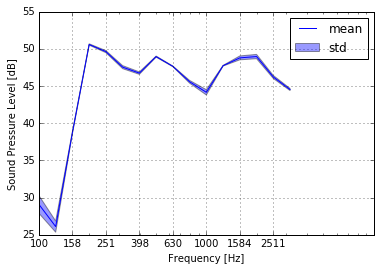

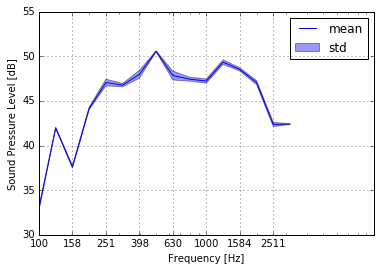

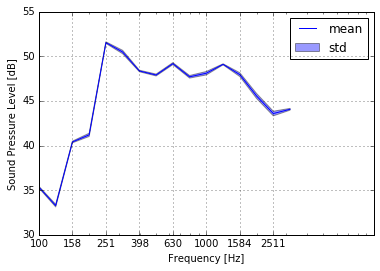

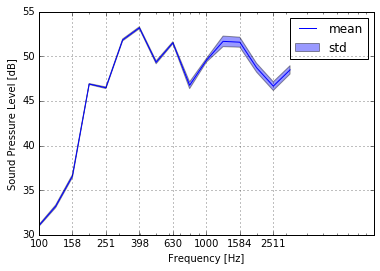

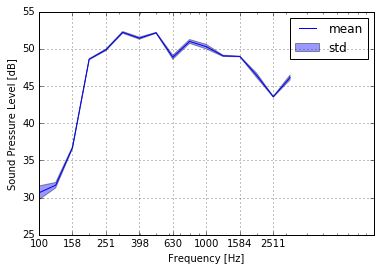

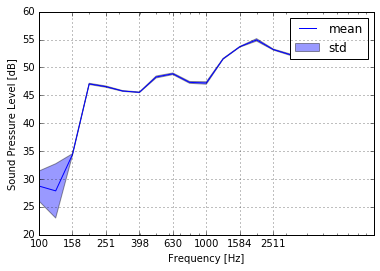

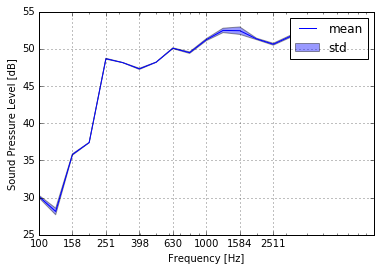

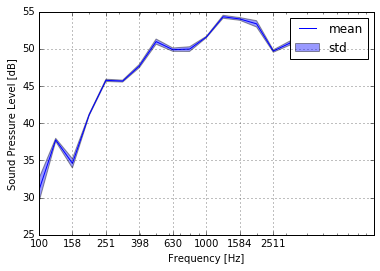

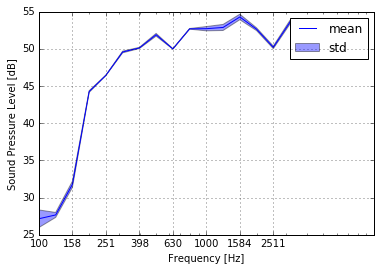

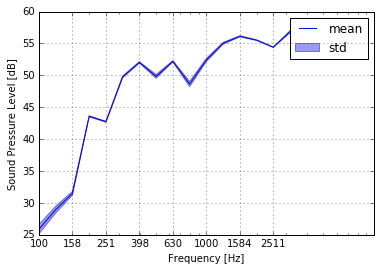

In [54]:
spl_test('../../data/SPL-Test/PcbMic/pink_noise/')
spl_test('../../data/SPL-Test/PcbMic/white_noise//')
# spl_test('../../data/SPL-Test/SounCard/pink_noise/')

In [58]:
# Octave bands
octave_bands = np.array([125, 250, 500, 1000, 2000, 4000])
y_label = 'Reverberation time [sec]'


# Pink Noise
pos1 = np.array([[36.0, 45.4, 48.1, 49.3, 45.2, 39.4],
                 [32.3, 43.9, 48.6, 49.7, 45.1, 39.5],
                 [37.9, 43.8, 49.6, 49.8, 45.5, 39.2]])

pos2 = np.array([[35.2, 47.2, 48.6, 50.8, 44.3, 39.7],
                 [33.3, 47.2, 47.7, 49.9, 44.2, 40.0],
                 [33.5, 47.3, 47.7, 49.3, 44.3, 39.6]])

pos3 = np.array([[34.6, 47.7, 50.1, 50.4, 46.2, 46.3],
                 [40.4, 49.0, 50.4, 50.7, 46.7, 44.4],
                 [38.3, 49.0, 49.6, 50.9, 46.4, 44.9]])

pos4 = np.array([[37.9, 44.4, 46.7, 47.4, 46.7, 39.7],
                 [41.1, 44.7, 46.2, 47.9, 46.9, 39.7],
                 [40.1, 43.2, 45.3, 50.0, 47.2, 40.6]])

pos5 = np.array([[36.6, 47.8, 48.3, 52.0, 48.5, 45.5],
                 [35.1, 47.8, 46.1, 51.8, 49.7, 46.3],
                 [36.7, 48.7, 48.0, 52.8, 48.9, 45.5]])
plot_app_data([pos1, pos2, pos3, pos4, pos5], octave_bands, y_label, ['pos1', 'pos2', 'pos3', 'pos4', 'pos5'])

In [59]:
# White noise
pos1 = np.array([[32.7, 44.0, 50.2, 54.6, 52.5, 46.7],
                 [31.7, 42.2, 48.9, 54.1, 51.2, 47.8],
                 [31.6, 43.7, 50.5, 54.3, 51.8, 46.5]])

pos2 = np.array([[28.1, 43.7, 49.2, 55.0, 50.5, 47.6],
                 [27.2, 45.3, 49.5, 53.3, 51.3, 48.6],
                 [28.8, 45.1, 49.2, 53.4, 51.6, 48.7]])

pos3 = np.array([[37.4, 46.3, 51.7, 54.7, 53.3, 53.5],
                 [35.8, 46.3, 51.8, 55.4, 53.4, 53.6],
                 [32.9, 47.0, 51.4, 55.0, 52.7, 53.7]])

pos4 = np.array([[33.8, 41.8, 47.1, 53.2, 53.3, 49.4],
                 [38.2, 42.8, 47.4, 52.1, 54.4, 49.7],
                 [37.9, 42.1, 46.4, 51.9, 53.6, 49.1]])

pos5 = np.array([[33.3, 46.0, 49.7, 56.2, 55.9, 54.8],
                 [32.9, 47.3, 48.0, 56.9, 55.7, 54.9],
                 [33.0, 45.4, 49.8, 54.9, 57.3, 55.1]])
plot_app_data([pos1, pos2, pos3, pos4, pos5], octave_bands, y_label, ['pos1', 'pos2', 'pos3', 'pos4', 'pos5'])

In [44]:
def test_yied(root_dir, args='source'):
    data_folders = get_immediate_subdirectories(root_dir)
    
    count = 0
    for data_foo in data_folders:
        sub_foos = get_immediate_subdirectories(root_dir + data_foo)
        
        for foo in sub_foos:
            if foo == args:
                files = os.listdir(root_dir + data_foo + '/' + foo)
                rt60_list = list()
                
                for f in files:
                    file_path = root_dir + data_foo + '/' + foo + '/' + f
                    
                    yield load_data(file_path)
data = test_yied('../../data/RT-Test/stair-case/')
c = 0
for d in data:
    c += 1
print c

15


-22.3988159012


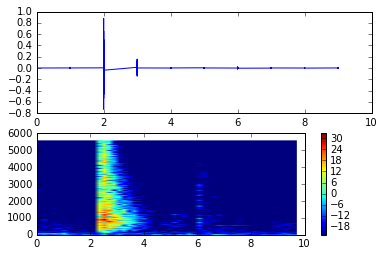

In [187]:
data = np.load('../../data/RT-Test/stair-case/2018-06-27-121930/background/5.npy')  # the signal
#data = abs(data / np.max(data))
NFFT = 1024 * 4       # the length of the windowing segments
Fs = 11025  # the sampling frequency
t = np.arange(data.size) / Fs


# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage
# instance

s = np.abs(np.fft.rfft(data))
vmin = 20 * np.log10(np.max(s)) - 60
#vmin = -30

print vmin

ax1 = plt.subplot(211)
plt.plot(t, data)
plt.subplot(212, sharex=ax1)
Pxx, freqs, bins, im = plt.specgram(data, NFFT=NFFT, Fs=Fs, noverlap=NFFT/2, mode='magnitude', vmin=vmin)
plt.colorbar(im)
plt.show()


In [ ]:
plt.savefig()